In [153]:
import acquire
import prep
import split_scale
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import median_absolute_error, explained_variance_score
from mpl_toolkits.mplot3d import Axes3D

In [2]:


# read sql data from csv to minimize lag
# df = pd.read_csv(r'/Users/mists/codeup-data-science/zillow-cluster/query_result.csv')
df = pd.read_csv(r'/Users/cris/codeup-data-science/zillow-cluster/query_result.csv')

In [3]:
# wrangle_zillow code here
df = acquire.wrangle_zillow(df)

In [4]:
df = prep.handle_missing_values(df,.90,.40)

In [5]:
df = prep.clean_columns(df)

In [6]:
df = prep.drop_minimal_nulls(df)

In [7]:
df = prep.pretty_cols(df)

In [8]:
df = prep.cal_taxrate(df)

In [9]:
df.transactiondate = pd.to_datetime(df.transactiondate)
df.countyid = df.countyid.astype("category")

In [10]:
train, test = split_scale.split_my_data(df, .80)

In [11]:
train, test = prep.impute_lotsize_nulls(train, test)

In [12]:
train = prep.cal_land_area(train)
test = prep.cal_land_area(test)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41680 entries, 28235 to 54472
Data columns (total 15 columns):
countyid           41680 non-null category
latitude           41680 non-null int64
longitude          41680 non-null int64
yearbuilt          41680 non-null float64
bathroomcnt        41680 non-null float64
bedroomcnt         41680 non-null int64
house_area         41680 non-null float64
house_value        41680 non-null float64
land_value         41680 non-null float64
whole_area         41680 non-null float64
whole_value        41680 non-null float64
logerror           41680 non-null float64
transactiondate    41680 non-null datetime64[ns]
taxrate            41680 non-null float64
land_area          41680 non-null float64
dtypes: category(1), datetime64[ns](1), float64(10), int64(3)
memory usage: 6.1 MB


---

In [14]:
#transaction date is removed in train (for exploration purposes)
train_ex = train.copy()
train_ex = train_ex.drop(columns="transactiondate")

test_ex = test.copy()
test_ex = test_ex.drop(columns="transactiondate")

In [15]:
train_ex, test_ex, scaler = split_scale.standard_scaler(train_ex, test_ex)

trex is train:
    - without the transaction date
    - scaled to normal distribution

In [16]:
train_ex_home = train_ex[["logerror","bathroomcnt","bedroomcnt","house_area","land_area","whole_area","yearbuilt"]]
train_ex_loc = train_ex[["logerror","latitude","longitude","countyid"]]
train_ex_val = train_ex[["logerror","house_value","land_value","whole_value","taxrate"]]

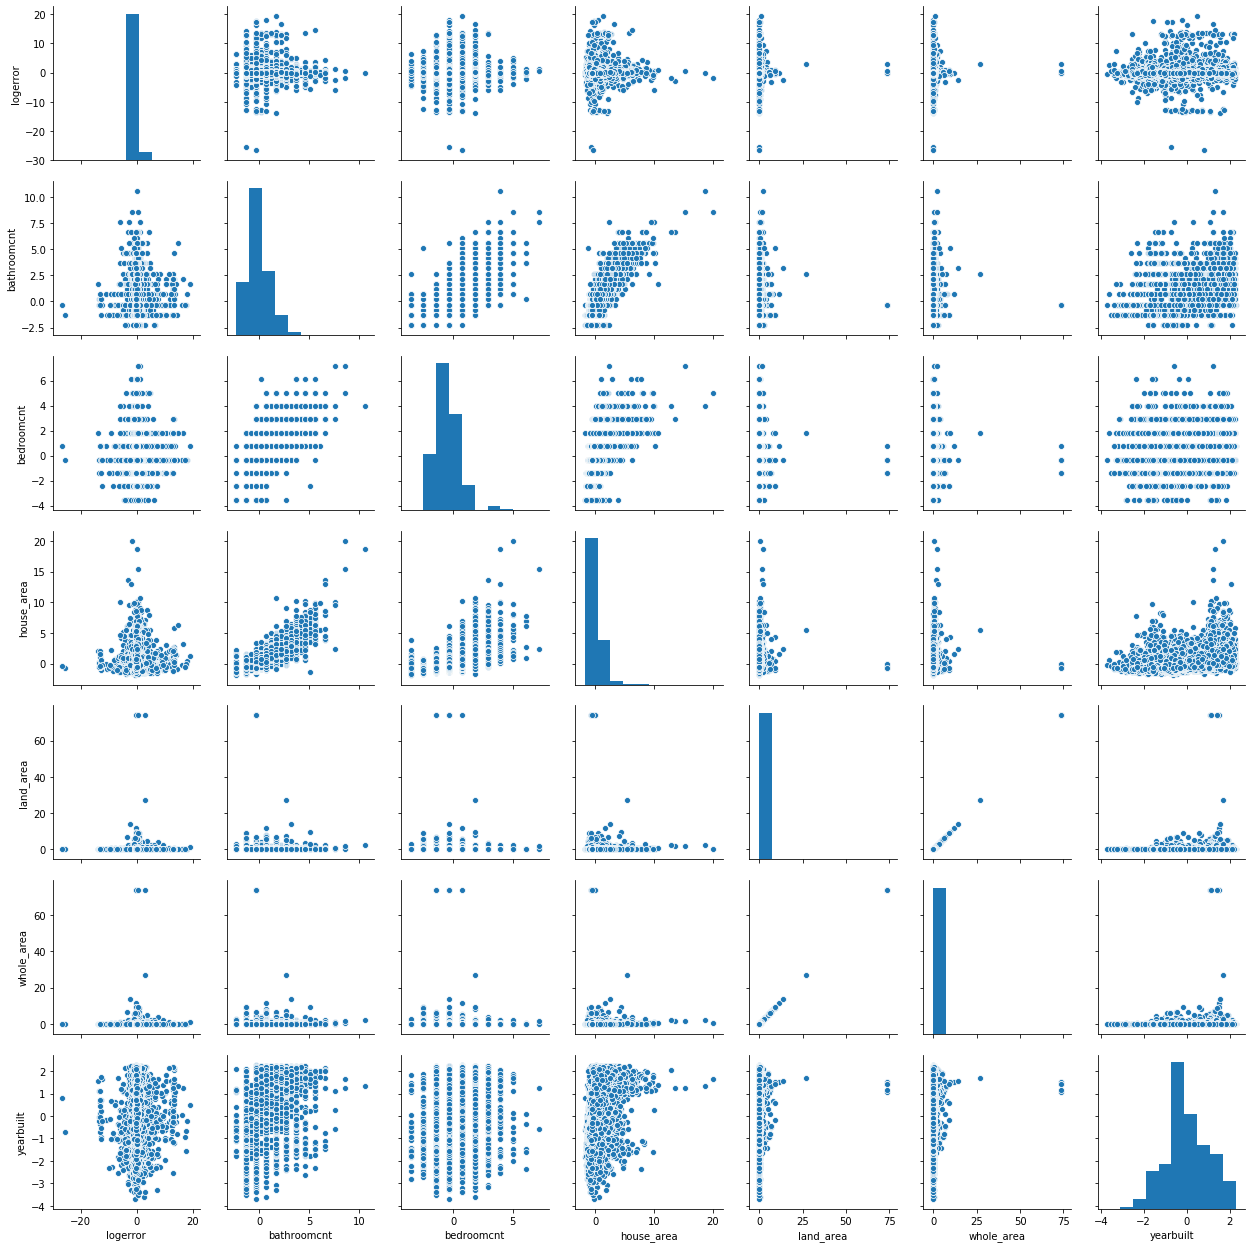

In [17]:
sns.pairplot(train_ex_home)

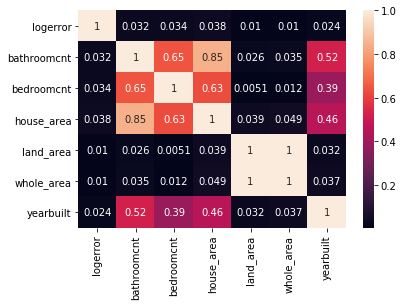

In [18]:
sns.heatmap(train_ex_home.corr(), annot=True)

`bathroomcnt` and `bedroomcnt` have strong positive correlation with `house_area`. These features can be dropped. Likewise, `land_area` is a derivative of the data we know previously which was `whole_area` (prev. lotsize) so they're very strongly correlated. We can drop the `whole_area` for now.
  
Recall that `land_area` is a derived feature from finished sqft and lot size. We inferred that a big house, does not always entail a big land which is why we separated land and house area in the first place. Seeing a low (0.15) correlation between `land_area` and `house_area` confirms that it was a good move to separate these features.
  
It's also interesting to note that `house_area` has a fairly strong positive correlation with `yearbuilt` and it's probably due to the style of house built during that era (craftsman, neoclassical, ranch style, etc.). Even if they are correlated, year built provides a distinct information on the property so we will keep it.

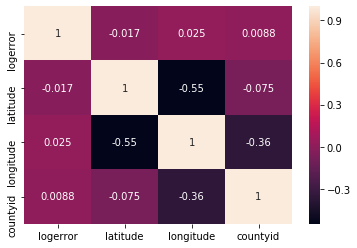

In [19]:
sns.heatmap(train_ex_loc.corr(),annot=True)

No correlations stand out from the house group, but it's worth noting that `latitude` and `longitude` have strong negative correlation. It means that as we move eastwards, we move southwards, which geographically makes sense as we are considering counties in Los Angeles (forms a downsloping diagonal line).

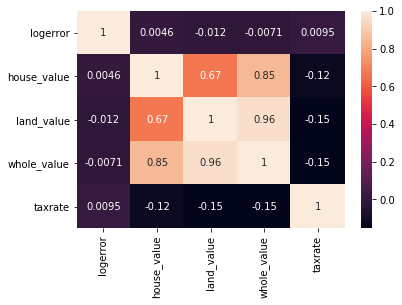

In [20]:
sns.heatmap(train_ex_val.corr(),annot=True)

`whole_value` is the sum of `land_value` and `house_value`, so a positive high correlation of .95 and .8 is expected. We can drop `whole_value` as a feature for the model.
  
The `tax_rate` having strong negative correlations with `land_value` is something to note.

<div class="alert alert-block alert-info">
<b>TAKEAWAY:</b>  
    
- None of the features seem to highly correlate with logerror. But it makes me think that its possibly because of two things:
    1. Logerror is a derived feature. It's not as straightforward as property value.
    2. Logerror is drived by a summation of different things, random and predictable. It's a multi-dimensional problem that needs more than x predicts y.
- Pearson's r does not show statistical significance. Instead of thinking that none of these features drive logerror, it strengthens the idea of exploring clustering more to address the dimensionality of the features.
- With the above being said, instead of using pearson's r to both (1) see strong drivers in explaining logerror, and (2) check for multicollinear features, we will only use it to address multicollinearity and inform us what features to drop.
- **Features to Keep based on Pearson's Correlation**
 - Home Group  
   - land_area  
   - house_area  
   - yearbuilt  
 - Location Group  
   - latitude  
   - longitude  
   - county_id  
 - Valuation Group  
   - house_value  
   - land_value  
   - taxrate  
</div>

---

In [21]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(train_ex_home[["logerror","land_area","house_area"]])

clusters = pd.DataFrame(kmeans.predict(train_ex_home[["logerror","land_area","house_area"]]))

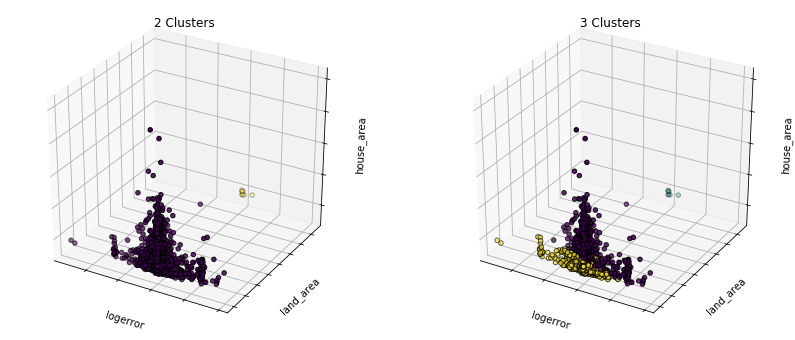

In [22]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('3 Clusters', KMeans(n_clusters=3))]

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})

for ax, (title, kmeans) in zip(axs, estimators):
    # fit the kmeans object
    kmeans.fit(train_ex_home[["logerror","land_area","house_area"]])

    labels = kmeans.labels_

    ax.scatter(train_ex_home.logerror, 
               train_ex_home.land_area, 
               train_ex_home.house_area,
               c=labels.astype(np.float), edgecolor='k')
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
    ax.set(xlabel='logerror', ylabel='land_area', zlabel='house_area')
    ax.set(title=title)

In [23]:
train_ex_loc.groupby("countyid").count()

,logerror,latitude,longitude
countyid,,,
-0.577331,26935,26935,26935
0.472508,11286,11286,11286
2.953945,3459,3459,3459


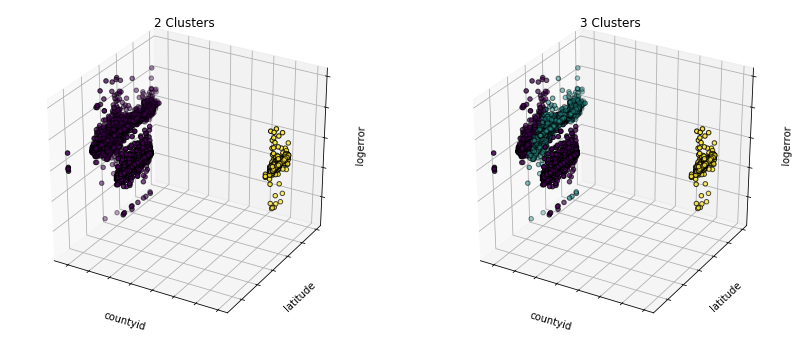

In [24]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('3 Clusters', KMeans(n_clusters=3))]

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})

for ax, (title, kmeans) in zip(axs, estimators):
    # fit the kmeans object
    kmeans.fit(train_ex_loc[["logerror","latitude","countyid"]])

    labels = kmeans.labels_

    ax.scatter(train_ex_loc.countyid, 
               train_ex_loc.latitude, 
               train_ex_loc.logerror,
               c=labels.astype(np.float), edgecolor='k')
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
    ax.set(xlabel='countyid', ylabel='latitude', zlabel='logerror')
    ax.set(title=title)

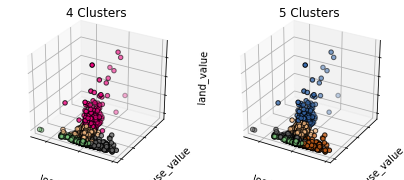

In [25]:
estimators = [('4 Clusters', KMeans(n_clusters=4)),
              ('5 Clusters', KMeans(n_clusters=5))]

fig, axs = plt.subplots(1, 2, figsize=(7, 3), subplot_kw={'projection': '3d'})

for ax, (title, kmeans) in zip(axs, estimators):
    # fit the kmeans object
    kmeans.fit(train_ex_val[["logerror","house_value","land_value"]])

    labels = kmeans.labels_

    ax.scatter(train_ex_val.logerror, 
               train_ex_val.house_value, 
               train_ex_val.land_value,
               c=labels.astype(np.float), edgecolor='k',cmap="Accent")
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
    ax.set(xlabel='logerror', ylabel='house_value', zlabel='land_value')
    ax.set(title=title)
    
#     train_ex_val = train_ex[["logerror","house_value","land_value","whole_value","taxrate"]]

    k            sse
0   1  125040.000000
1   2   90841.614124
2   3   75070.514580
3   4   60197.499244
4   5   53256.526416
5   6   46651.378982
6   7   40987.273520
7   8   36429.966142
8   9   33674.600129
9  10   31039.577472


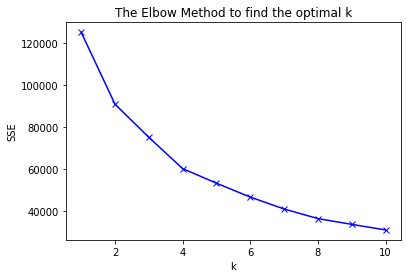

In [26]:
ks = range(1,11)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_ex_val[["logerror","house_value","land_value"]])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

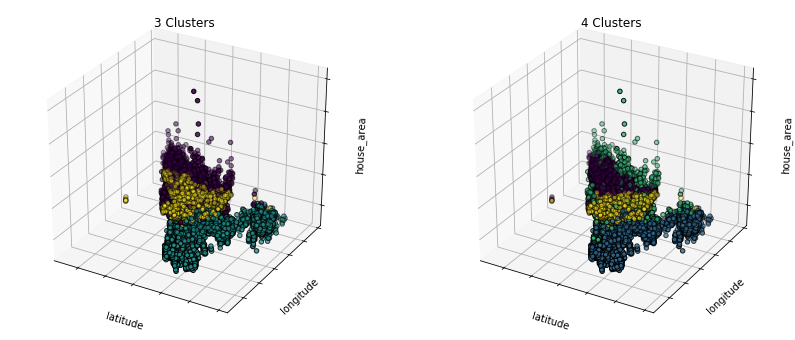

In [27]:
estimators = [('3 Clusters', KMeans(n_clusters=3)),
              ('4 Clusters', KMeans(n_clusters=4))]

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})

for ax, (title, kmeans) in zip(axs, estimators):
    # fit the kmeans object
    kmeans.fit(train_ex[["latitude","longitude","house_area"]])

    labels = kmeans.labels_

    ax.scatter(train_ex.latitude, 
               train_ex.longitude, 
               train_ex.house_area,
               c=labels.astype(np.float), edgecolor='k')
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
    ax.set(xlabel='latitude', ylabel='longitude', zlabel='house_area')
    ax.set(title=title)

Defining how many cluster_house

    k            sse
0   1  125040.000000
1   2   86633.057977
2   3   48467.264429
3   4   36183.098328
4   5   29263.571423
5   6   24548.395734
6   7   20275.833075
7   8   18184.240150
8   9   16358.762389
9  10   15015.102051


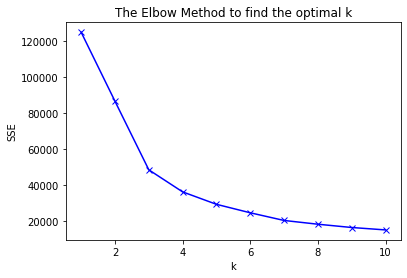

In [199]:
ks = range(1,11)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_ex[["land_area","house_area","yearbuilt"]])
    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

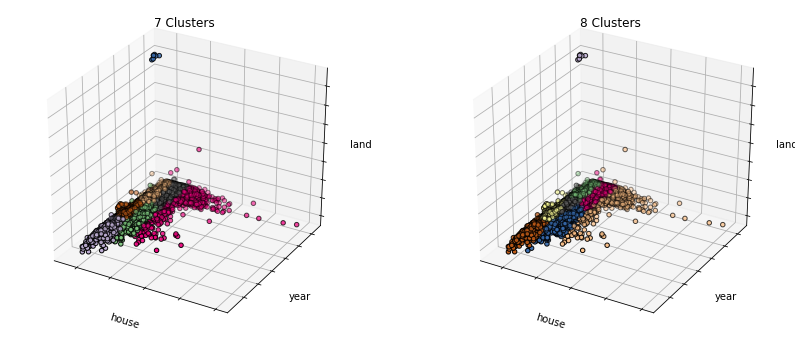

In [202]:
estimators = [('7 Clusters', KMeans(n_clusters=7)),
              ('8 Clusters', KMeans(n_clusters=8))]

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})

for ax, (title, kmeans) in zip(axs, estimators):
    # fit the kmeans object
    kmeans.fit(train_ex[["house_area","yearbuilt","land_area"]])

    labels = kmeans.labels_

    ax.scatter(train_ex.house_area, 
               train_ex.yearbuilt, 
               train_ex.land_area,
               c=labels.astype(np.float), edgecolor='k',cmap="Accent")
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
    ax.set(xlabel='house', ylabel='year', zlabel='land')
    ax.set(title=title)

In [203]:
kmeans_house = KMeans(n_clusters=8)
cluster_house = pd.DataFrame(kmeans_house.fit_predict(train_ex[["house_area","land_area","yearbuilt"]]),index=train_ex.index)
train_ex["cluster_house"] = cluster_house.copy()

In [204]:
train_ex.cluster_house.describe()

count    41680.000000
mean         2.839659
std          2.142747
min          0.000000
25%          1.000000
50%          4.000000
75%          4.000000
max          7.000000
Name: cluster_house, dtype: float64

---

Defining how many cluster_loc

    k            sse
0   1  123280.294722
1   2   61744.409731
2   3   40280.773632
3   4   22371.192220
4   5   16447.772681
5   6   12665.879580
6   7   10124.526867
7   8    8482.228294
8   9    7635.456849
9  10    6992.040814


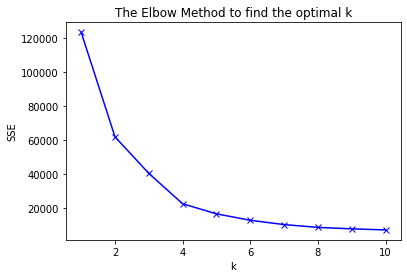

In [40]:
ks = range(1,11)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_ex[["latitude","longitude","cluster_loc"]])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)   
    
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_ex[["latitude","longitude","cluster_loc"]])
    
print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

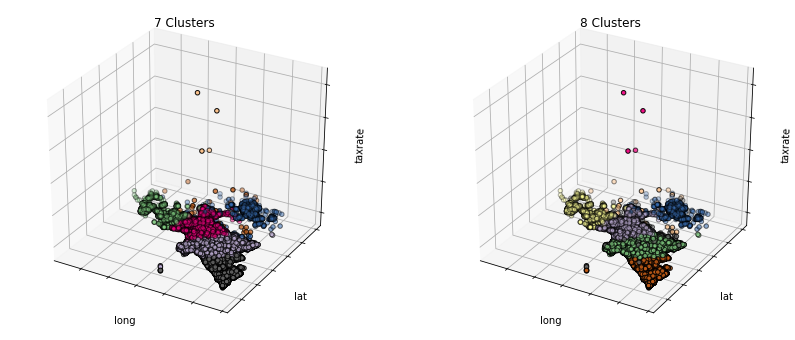

In [201]:
estimators = [('7 Clusters', KMeans(n_clusters=7)),
              ('8 Clusters', KMeans(n_clusters=8))]

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})

for ax, (title, kmeans) in zip(axs, estimators):
    # fit the kmeans object
    kmeans.fit(train_ex[["longitude","latitude","taxrate"]])

    labels = kmeans.labels_

    ax.scatter(train_ex.longitude, 
               train_ex.latitude, 
               train_ex.taxrate,
               c=labels.astype(np.float), edgecolor='k',cmap="Accent")
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
    ax.set(xlabel='long', ylabel='lat', zlabel='taxrate')
    ax.set(title=title)

In [205]:
kmeans_loc = KMeans(n_clusters=7)
cluster_loc = pd.DataFrame(kmeans_loc.fit_predict(train_ex[["longitude","latitude","taxrate"]]),index=train_ex.index)
train_ex["cluster_loc"] = cluster_loc.copy()

In [206]:
train_ex.cluster_loc.describe()

count    41680.000000
mean         2.079966
std          1.928348
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
max          6.000000
Name: cluster_loc, dtype: float64

---

In [167]:
from scipy import stats

In [214]:
ttest_list = []
pval_list = []
for cluster in train_ex.cluster_house.unique():
    ttest, pval = stats.ttest_1samp(train_ex.logerror[train_ex.cluster_house == cluster],train_ex.logerror.mean(),axis=0,nan_policy="propagate")
    ttest_list.append(ttest)
    pval_list.append(pval)
print(ttest_list)
print(pval_list)

[-2.082980968214215, 0.8503864138940822, -3.0739852487185635, 2.0716793704715664, 4.346186525057437, -3.308244599795854, 3.509865132860009, 0.9162823484061319]
[0.037270517915826334, 0.3951314250519863, 0.002122489892145715, 0.03838492770184666, 1.4172816873654742e-05, 0.0009465850376832048, 0.000479901759283079, 0.39485422892111993]


In [215]:
house_dict = {"ttest":ttest_list,"pval":pval_list}
stats_cluster_house = pd.DataFrame(house_dict)
stats_cluster_house

,ttest,pval
0,-2.082981,0.037271
1,0.850386,0.395131
2,-3.073985,0.002122
3,2.071679,0.038385
4,4.346187,0.000014
5,-3.308245,0.000947
6,3.509865,0.000480
7,0.916282,0.394854


In [217]:
ttest_list_loc = []
pval_list_loc = []
for cluster in train_ex.cluster_loc.unique():
    ttest, pval = stats.ttest_1samp(train_ex.logerror[train_ex.cluster_loc == cluster],train_ex.logerror.mean(),axis=0,nan_policy="propagate")
    ttest_list_loc.append(ttest)
    pval_list_loc.append(pval)

In [218]:
loc_dict = {"ttest_loc":ttest_list_loc,"pval_loc":pval_list_loc}
stats_cluster_loc = pd.DataFrame(loc_dict)
stats_cluster_loc

,ttest_loc,pval_loc
0,-4.832767,0.000001
1,0.977721,0.328227
2,-0.747773,0.454648
3,3.832153,0.000128
4,0.212731,0.831551
5,1.625969,0.108582
6,-0.230454,0.832560


---

In [ ]:
lm1.fit(X_train, y_train)
print("Linear Model:", lm1)

lm1_y_intercept = lm1.intercept_
print("intercept: ", lm1_y_intercept)

lm1_coefficients = lm1.coef_
print("coefficients: ", lm1_coefficients)

In [93]:
X_train_ex= train_ex[["cluster_house","cluster_loc","house_value","land_value"]]
y_train_ex= train_ex.logerror

In [115]:
from sklearn.linear_model import LinearRegression

lmc = LinearRegression()
lmc.fit(X_train_ex, y_train_ex)

yhat_lmc = lmc.predict(X_train_ex)

In [121]:
train_ex.logerror.describe()

count    4.168000e+04
mean    -1.876332e-17
std      1.000012e+00
min     -2.665129e+01
25%     -2.411773e-01
50%     -6.138676e-02
75%      1.300815e-01
max      1.925830e+01
Name: logerror, dtype: float64

In [126]:
train_ex.logerror.mean()

-1.8763315171155665e-17

In [139]:
predictions = pd.DataFrame(train_ex.logerror)
predictions["logerror_mean"] = predictions.logerror.mean()
predictions["logerror_model_c"] = yhat_lmc

In [140]:
predictions

,logerror,logerror_mean,logerror_model_c
28235,-0.440013,-1.876332e-17,-0.276150
22023,1.416194,-1.876332e-17,-0.262442
56314,0.523506,-1.876332e-17,-0.270393
29544,-0.029789,-1.876332e-17,-0.274299
11615,-0.092007,-1.876332e-17,-0.274345
25038,-0.383022,-1.876332e-17,0.375388
35654,0.183758,-1.876332e-17,0.390166
31267,0.149324,-1.876332e-17,-0.287294
14062,-1.080930,-1.876332e-17,-0.233079
11816,0.650470,-1.876332e-17,-0.251177


In [145]:
mae_baseline = median_absolute_error(predictions.logerror,predictions.logerror_mean)
mae_model = median_absolute_error(predictions.logerror,predictions.logerror_model_c)

In [147]:
print(f"""
      mae baseline = {mae_baseline}
      mae model = {mae_model}
""")


      mae baseline = 0.1965713046059906
      mae model = 0.33616825286827523



In [151]:
evs_model = explained_variance_score(predictions.logerror,predictions.logerror_model_c)
evs_baseline = explained_variance_score(predictions.logerror,predictions.logerror_mean)

In [152]:
print(f"""
      r2 baseline = {evs_baseline}
      r2 model = {evs_model}
""")


      r2 baseline = 0.0
      r2 model = 0.258629390677937

